# CDA Lab 1 - Credit Card Fraud
### By Christiaan van den Bogaard and Ruben Groot-Roessink


### Introduction
This notebook covers the lab assignment for the CDA lab assignment 1, it uses Python 3.  For this we will mainly use Pandas for data processing and SKlearn for machine learning. The code is explained in the textbove above the code or more detailed in the comments.
### Features:

- issuercountrycode: country where the card was issued
- txvariantcode: the card type that was used (subbrand of visa or master card)
- bin: card issuer identifier
- amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
- shoppercountrycode: IP address country
- shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
- simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
- bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
- cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
- cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
- creationdate: Date of transaction
- accountcode: merchant’s webshop
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score
import pandas_ml as pdml
import imblearn
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings(action='once')
from sklearn.model_selection import *
from imblearn.over_sampling import SMOTE, ADASYN
sns.set()


In [2]:
# parse time with seconds to general date
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('data.csv', parse_dates=['bookingdate'], date_parser=dateparse)
data['bookingdate'] = data['bookingdate'].dt.date

# We decide for now to drop the booking date
data.drop(['bookingdate'], axis=1);
# remove refused entries
data = data[data.simple_journal != 'Refused']
# map the currencies to the right value, and calculate it in eur values
currency_dict = {'MXN': 0.01*0.05, 'SEK': 0.01*0.11, 'AUD': 0.01*0.67, 'GBP': 0.01*1.28, 'NZD': 0.01*0.61}
data['euro'] = 0
data['euro'] = data.apply(lambda row: currency_dict[row['currencycode']]*row['amount'], axis=1)

# Fill nas with missing
# data = data.fillna('missing')
# distinguish datasets for data exploration
data_benign = data[data.simple_journal == 'Settled']
data_fraud  = data[data.simple_journal == 'Chargeback']


datax=  data
data.head()




,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,euro
0,1,2015-11-09,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,32.40
1,2,2015-11-09,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,22.45
2,3,2015-11-23,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,74.95
3,4,2015-11-23,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,54.95
4,5,2015-11-09,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,44.95


In [8]:
# Remap values no greater than 3
data[['cvcresponsecode']] = data[['cvcresponsecode']].replace({0:0,1:1,2:2,3:3,4:3,5:3,6:3}) 
# Normalise the euro valus within 0-1 range
min_max_scaler = preprocessing.MinMaxScaler()
data[['euro']] = min_max_scaler.fit_transform(data[['euro']])
# This is the data we are going to use
data_select = data[['euro','issuercountrycode', 'txvariantcode',
        'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
        'accountcode']]
# This is the data which needs to be encoded for one hot encoding
categorical = ['issuercountrycode', 'txvariantcode',
       'currencycode', 'shoppercountrycode', 'shopperinteraction',
        'cardverificationcodesupplied', 'cvcresponsecode',
        'accountcode']

# Run one hot encoding, we find the pandas one hot encoder somehwat faster than
# the one supplied with SK learn. It does the same thing.
data_with_dummies = pd.get_dummies( data_select, columns =  categorical)
# Remap values to an int value for simplicity
y_in_pd = data_with_dummies['simple_journal'].replace({'Chargeback':1, 'Settled':0})
x_in_pd = data_with_dummies.drop(['simple_journal'], axis=1)

# Split testsizes for the ROC analysis
training_features, test_features, training_target, test_target, = train_test_split(data_with_dummies.drop(['simple_journal'], axis=1),
                                               data_with_dummies['simple_journal'],
                                               test_size = .1,)


# Smote data for ROC analysis, we use minority sampling
# Only smote training data!
sampler = SMOTE(kind='regular', ratio='minority')
smote_training_features, smote_training_target = sampler.fit_sample(training_features, training_target)





### ROC ANALYSIS
In these code blocks we are generating ROC curves for 3 different algorithms,, for both SMOTED and NON SMOTED data:
RandomForest
Logistic Regression
KNN

Returns: Prediction values and ROC curve

The code in these three blocks are generally the same but are ran in different blocks to keep the results saved.


Running Random-Forest NoSmote
TP: 2
FP: 5
FN: 30
TN: 23667
Running Random-Forest Smote
TP: 6
FP: 541
FN: 26
TN: 23131


C:\Users\Christiaan\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


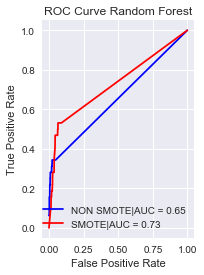

In [23]:
print("Running Random-Forest NoSmote")
# Specify cutoff value, 
cutoff=0.6
clf_rf1 = RandomForestClassifier(n_estimators=20, criterion='gini')
clf_rf1.fit(training_features, training_target)
predict_proba = clf_rf1.predict_proba(test_features)
y_predict = (predict_proba[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


test_target = test_target.astype(np.int64)
false_positive_rate, true_positive_rate, thresholds1 = 0,0,0
false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.subplot(1, 2, 2)
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'NON SMOTE|AUC = %0.2f'% roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

print("Running Random-Forest Smote")
cutoff=0.6
clf_rf = RandomForestClassifier(n_estimators=25, criterion='gini')
clf_rf.fit(smote_training_features, smote_training_target)
predict_proba_smote = clf_rf.predict_proba(test_features)
y_predict = (predict_proba_smote[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


test_target = test_target.astype(np.int64)

false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba_smote[:,0])

roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.plot(false_positive_rate, true_positive_rate, 'r', label = 'SMOTE|AUC = %0.2f'% roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend(loc="lower right")



Running Logistic Regression NoSmote


C:\Users\Christiaan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


TP: 0
FP: 0
FN: 32
TN: 23672
Running Logistic Regression Smote
[0 0 0 ..., 0 0 0]
TP: 27
FP: 1463
FN: 5
TN: 22209
[  0.00000000e+00   4.22440014e-05   2.06995607e-03 ...,   9.97972288e-01
   9.98056776e-01   1.00000000e+00]


Text(0.5,1,'ROC Curve- Logistic Regression')

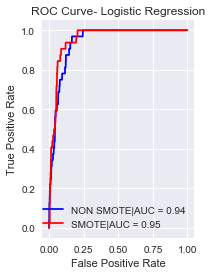

In [ ]:

#Logistic Regression- no smote o
print("Running Logistic Regression NoSmote")
cutoff=0.75
clf_lr = linear_model.LogisticRegression()
clf_lr.fit(training_features, training_target)
predict_proba = clf_lr.predict_proba(test_features)
y_predict = (predict_proba[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.subplot(1, 2, 1)
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'NON SMOTE|AUC = %0.2f'% roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')


print("Running Logistic Regression Smote")
cutoff=0.75
clf_lr = linear_model.LogisticRegression()
clf_lr.fit(smote_training_features, smote_training_target)
predict_proba_smote = clf_lr.predict_proba(test_features)
y_predict = (predict_proba_smote[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
print(test_target)
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


test_target = test_target.astype(np.int64)

false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba_smote[:,0])
print(false_positive_rate)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.plot(false_positive_rate, true_positive_rate, 'r', label = 'SMOTE|AUC = %0.2f'% roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')



In [ ]:
print("Running KNN Non Smote")
cutoff=0.60
clf_lr1 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
clf_lr1.fit(training_features, training_target)
predict_proba = clf_lr1.predict_proba(test_features)
y_predict = (predict_proba[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
print(test_target)
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


test_target = test_target.astype(np.int64)

false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.subplot(1, 2, 1)
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'NON SMOTE|AUC = %0.2f'% roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')

print("Running KNN Smote")
cutoff=0.60
clf_lr = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
clf_lr.fit(smote_training_features, smote_training_target)
predict_proba_smote = clf_lr.predict_proba(test_features)
y_predict = (predict_proba_smote[:,0]>cutoff).astype(int)
FP,TP,FN,TN= 0,0,0,0
test_target = np.array(test_target)
test_target[test_target == 'Chargeback']= 1
test_target[test_target == 'Settled']= 0
print(test_target)
for i in range(len(y_predict)):
    if test_target[i]==1 and y_predict[i]==1:
        TP += 1
    if test_target[i]==0 and y_predict[i]==1:
        FP += 1
    if test_target[i]==1 and y_predict[i]==0:
        FN += 1
    if test_target[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


test_target = test_target.astype(np.int64)

false_positive_rate, true_positive_rate, thresholds1 = roc_curve(test_target, predict_proba_smote[:,0])
print(false_positive_rate)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(3)
plt.plot(false_positive_rate, true_positive_rate, 'r', label = 'SMOTE|AUC = %0.2f'% roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')

Running KNN Non Smote


### Creating a good classifier
In this section we will try to optimize our classifier using 10 splits StratifiedKFold. This splits it even parts and sums it up.
As a white box classifier we will use LogisticRegression. 
Differnet settings can be applied, for optimal settings please reference to our paper.
We will use hyper parameter tuning to get optimal C value for Logisitc Regression. This currently is commented out because it takes a very long time to compute! 
Settings:
* k: N_component for PCA
* cutoff: Set cutoff value for the predictions, higher means lower true positives but less false positive

In [84]:
# Hyper parameter tuning takes very long!
param_grid = {'C':np.logspace(-5,2, num=10)}
lr = linear_model.LogisticRegression()
# kf = StratifiedKFold(n_splits=1)
gscv = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1)
# gscv.fit(smote_training_features, smote_training_target)

# results in {'C': 0.4641588833612782}

{'C': 0.4641588833612782}


In [22]:

cutoff = 0.9
skf = StratifiedKFold(n_splits=10)
k=5
TP, FP, FN, TN = 0, 0, 0, 0
clf = linear_model.LogisticRegression(C= .4641588833612782)
sampler = SMOTE(ratio='minority', kind='regular')
x_in = x_in_pd.as_matrix()
y_in = y_in_pd.as_matrix()
cv = skf.split(x_in, y_in)
j = 0
for train_index, test_index in cv:
    train_x, train_y = sampler.fit_sample(x_in[train_index], y_in[train_index])
#     pca = PCA(n_components=k)
#     pipe = Pipeline([('pca', pca), ('logistic', clf)])
    clf.fit(train_x, train_y)
    predict_proba = clf.predict_proba(x_in[test_index])
    y_predict = (predict_proba[:,1]>cutoff).astype(int)
    y_res = y_in[test_index]
    for i in range(len(y_predict)):
        y_res_val = y_res[i]
        y_predict_val = y_predict[i]
        if y_res_val==1 and y_predict_val==1:
            TP += 1
        if y_res_val==0 and y_predict_val==1:
            FP += 1
        if y_res_val==1 and y_predict_val==0:
            FN += 1
        if y_res_val==0 and y_predict_val==0:
            TN += 1
    j += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))


# UNCOMMENT IF YOU WANT TO PRINT SORTED FEATURE COEFFICIENTS

# importances = (clf.coef_)
# feature_list = training_features.columns.values
# res = zip(feature_list, importances)
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances[0])]
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]




TP: 146
FP: 12309
FN: 199
TN: 224382


In [9]:
depth = 11
feature = 0.2
cutoff = .8
skf = StratifiedKFold(n_splits=10)
TP, FP, FN, TN = 0, 0, 0, 0
clf =  RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs=-1, max_depth=depth)
sampler = SMOTE(ratio='minority', kind='regular')
x_in = x_in_pd.as_matrix()
y_in = y_in_pd.as_matrix()
cv = skf.split(x_in, y_in)
j = 0
for train_index, test_index in cv:
    train_x, train_y = sampler.fit_sample(x_in[train_index], y_in[train_index])
    clf.fit(train_x, train_y)
    predict_proba = clf.predict_proba(x_in[test_index])
    y_predict = (predict_proba[:,1]>cutoff).astype(int)
    y_res = y_in[test_index]
    for i in range(len(y_predict)):
        y_res_val = y_res[i]
        y_predict_val = y_predict[i]
        if y_res_val==1 and y_predict_val==1:
            TP += 1
        if y_res_val==0 and y_predict_val==1:
            FP += 1
        if y_res_val==1 and y_predict_val==0:
            FN += 1
        if y_res_val==0 and y_predict_val==0:
            TN += 1
    j += 1
print('cutoff ' + str(cutoff))
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))

cutoff 0.8
TP: 179
FP: 18253
FN: 166
TN: 218438


### Feature importance
This code calculates the feature importance of the classifier

In [8]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
feature_list = training_features.columns.values
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: currencycode_GBP     Importance: 0.17
Variable: cvcresponsecode_1    Importance: 0.13
Variable: cvcresponsecode_0    Importance: 0.11
Variable: accountcode_UKAccount Importance: 0.1
Variable: shoppercountrycode_GB Importance: 0.06
Variable: issuercountrycode_AU Importance: 0.05
Variable: shoppercountrycode_AU Importance: 0.05
Variable: accountcode_MexicoAccount Importance: 0.05
Variable: issuercountrycode_GB Importance: 0.04
Variable: issuercountrycode_MX Importance: 0.04
Variable: currencycode_AUD     Importance: 0.04
Variable: txvariantcode_visaclassic Importance: 0.03
Variable: txvariantcode_visadebit Importance: 0.03
Variable: txvariantcode_mccredit Importance: 0.02
Variable: currencycode_MXN     Importance: 0.02
Variable: shoppercountrycode_MX Importance: 0.02
Variable: euro                 Importance: 0.01
Variable: shopperinteraction_ContAuth Importance: 0.01
Variable: shopperinteraction_Ecommerce Importance: 0.01
Variable: cardverificationcodesupplied_False Importance

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Bonus assignment
In this bonus we will try to increase the classifiers performance by aggregating on the cards

In [100]:
# parse time with seconds to general date
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data_agg = pd.read_csv('data.csv', parse_dates=['bookingdate'], date_parser=dateparse)
data_agg['bookingdate'] = data_agg['bookingdate'].dt.date

# remove refused entries
data_agg = data_agg[data_agg.simple_journal != 'Refused']
# map the currencies to the right value, and calculate it in eur values
currency_dict = {'MXN': 0.01*0.05, 'SEK': 0.01*0.11, 'AUD': 0.01*0.67, 'GBP': 0.01*1.28, 'NZD': 0.01*0.61}
data_agg['euro'] = 0
data_agg['euro'] = data_agg.apply(lambda row: currency_dict[row['currencycode']]*row['amount'], axis=1)
data_agg = data_agg.drop(['bookingdate', 'creationdate', 'amount'], axis=1)
data_agg['simple_journal'] = data_agg['simple_journal'].replace({'Chargeback':1.0, 'Settled':0.0}).astype(float)

data_agg['bin'] = data_agg['bin'].astype(int)


In [120]:
   
# find which cards have hihg prob to be iused in fraud
# assumptions; High mean value in eur, high distribution in shopper country code, 
# Set probability treshold for card is used fraudulent
fraud_treshold = 0.01
# # issuer country code: one distribution of issuer country code on either mail_id or email_id 
aggregation = {
    'euro': 'mean',
    'simple_journal': 'mean',
    'bin': 'first',
    'txvariantcode': 'first',
    'issuercountrycode': 'first',
    'ip_id' : 'nunique',
    'shoppercountrycode' : 'nunique',
    'mail_id': 'nunique',
    'accountcode':'nunique'
}
# data_agg.simple_journal.value_counts()
data_agg.card_id.value_counts()
data_agg.txvariantcode.value_counts()
data_agg[data_agg['card_id'] == 'card14995'].ip_id.value_counts()
data_test = data_agg[['card_id','simple_journal','accountcode', 'bin', 'euro', 'txvariantcode', 'issuercountrycode', 'ip_id', 'shoppercountrycode','mail_id']]
grouped = data_test.groupby(data_test['card_id']).agg(aggregation)
grouped.sort_values(by=['simple_journal'], ascending=False).head()
grouped['is_used_fraud'] = False
grouped['is_used_fraud'] = np.where(grouped['simple_journal']>fraud_treshold, True, False)
grouped.is_used_fraud.value_counts()
grouped = grouped.drop(['simple_journal'] , axis=1)
# Remap values
y_in = grouped['is_used_fraud']
x_in = grouped.drop(['is_used_fraud'], axis=1)






False    210545
True        309
Name: is_used_fraud, dtype: int64

In [125]:
cutoff = 0.8
skf = StratifiedKFold(n_splits=10)
k=5
TP, FP, FN, TN = 0, 0, 0, 0
clf = linear_model.LogisticRegression()
sampler = SMOTE(ratio='minority', kind='regular')
x_in = x_in_pd.as_matrix()
y_in = y_in_pd.as_matrix()
cv = skf.split(x_in, y_in)
j = 0
for train_index, test_index in cv:
    train_x, train_y = sampler.fit_sample(x_in[train_index], y_in[train_index])
    pca = PCA(n_components=k)
    pipe = Pipeline([('pca', pca), ('logistic', clf)])
    pipe.fit(train_x, train_y)
    predict_proba = pipe.predict_proba(x_in[test_index])
    y_predict = (predict_proba[:,1]>cutoff).astype(int)
    y_res = y_in[test_index]
    for i in range(len(y_predict)):
        y_res_val = y_res[i]
        y_predict_val = y_predict[i]
        if y_res_val==1 and y_predict_val==1:
            TP += 1
        if y_res_val==0 and y_predict_val==1:
            FP += 1
        if y_res_val==1 and y_predict_val==0:
            FN += 1
        if y_res_val==0 and y_predict_val==0:
            TN += 1
    j += 1
print('cutoff rate ' + str(cutoff))
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))

cutoff rate 0.8
TP: 156
FP: 33807
FN: 189
TN: 202884


## Extra code
Used code for data analysis such as plots


C:\Users\Christiaan\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


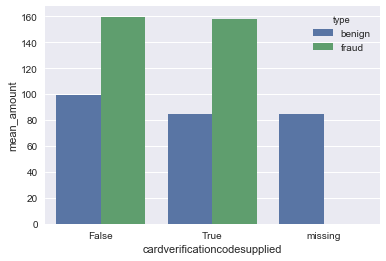

In [28]:
# Genereate heatmap for issuer countrycode and shopper countrycode
def generate_country_count(data):
    data_fraud = data[['issuercountrycode', 'shoppercountrycode']]
    data_grouped = data_fraud.groupby(['issuercountrycode', 'shoppercountrycode']).size().reset_index(name="count")
    pivot = data_grouped.pivot('issuercountrycode','shoppercountrycode').fillna(0)
    sns.heatmap(pivot, cmap="YlGnBu")
    

# Generates heatmap for 2 columns with a sum aggregation on amount
def generate_against_amount(data, col1, col2):
    data_fraud = data[[col1, col2, 'amount']]
    data_grouped = data_fraud.groupby([col1, col2])['amount'].agg('sum').reset_index(name='amount')
    pivot = data_grouped.pivot(index=col1, columns=col2, values='amount').fillna(0)
    sns.heatmap(pivot, cmap="YlGnBu")

# generate column against mean of amount
def generate_bar_mean(data, col):
    data_mean = data[[col, 'euro']].groupby([col])['euro'].agg('mean').reset_index(name='mean_amount')
    return data_mean

['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id'] 
x= 'cardverificationcodesupplied'
data_mean_fraud = generate_bar_mean(data_fraud, x)
data_mean_benign = generate_bar_mean(data_benign, x)
data_mean_fraud['type'] = 'fraud'
data_mean_benign['type']= 'benign'
data_mean = pd.concat([data_mean_benign, data_mean_fraud])


sns.barplot(x=x, y="mean_amount", hue="type", data=data_mean)

# figure = plot.get_figure()    
# figure.savefig('barchart_'+x+'.png', dpi=800)
# generate_against_amount(data_fraud, 'ip_id', 'card_id')





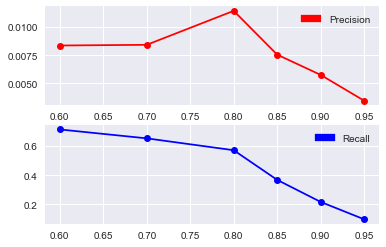

In [5]:
import matplotlib.patches as mpatches
rates = [.5,.6,.7,.8,.9,.95]
rates_bonus = [.6,.7,.8,.85,.9,.95]

tp_rates = [0.007514153,0.007809847,0.009037522,0.012505189,0.014609682,0.008621411]
recall = [0.846376812,0.8000,0.744927536,0.698550725,0.582608696,0.298550725]
tp_rates_bonus=[0.006489278,0.005988325,0.004593234,0.005151342,0.007451687,0.003332381]
recall_bonus =[0.808695652,0.689855072,0.452173913,0.443478261,0.263768116,0.101449275]

depth_rates = [1,2,3,4,5,6,7,8,9,10,11]
tp_rates_depth= [0,0.004005722,0.004161937,0.004889652,0.007967715,0.006195103,0.008177275,0.009785322,0.009458342,0.008877585,0.011298132]
recall_depth= [0,0.08115942,0.223188406,0.32173913,0.446376812,0.423188406,0.469565217,0.568115942,0.530434783,0.536231884,0.564841499]

# feature
depth_rates = [.1,.2,.4,.6,.8,1]
tp_rates_depth = [0.011018971,0.010937672,0.010739138,0.010196495,0.010098326,0]
recall_depth = [0.562318841,0.5768,0.568115942,0.556521739,0.550724638,0]

depth_rates = [.6,.7,.8,.85,.9,.95]
tp_rates_depth = [0.008363933,0.008425704,0.011442179,0.007551433,0.005752416,0.003459856]
recall_depth = [0.7130,0.652173913,0.571014493,0.368115942,0.217391304,0.098550725]

plt.figure(1)
plt.subplot(211)
red_patch = mpatches.Patch(color='red', label='Precision')
plt.legend(handles=[red_patch])
plt.plot(depth_rates, tp_rates_depth, 'r-', depth_rates, tp_rates_depth, 'ro')
plt.subplot(212)
blue_patch = mpatches.Patch(color='blue', label='Recall')
plt.legend(handles=[blue_patch])
plt.plot(depth_rates, recall_depth, 'b-',depth_rates, recall_depth, 'bo')
plt.show()
